In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, ParameterSampler
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import _rebuild
from statsmodels.stats.multitest import multipletests

_rebuild()
plt.rcParams['font.family']=['Microsoft YaHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False  # 用于正常显示负号

from utilitis.eda_utils import generate_img, create_characteristic_table
from utilitis.feature_manager import FeatureManager
from utilitis.model import XGBModel, to_xgb_dm

%load_ext autoreload
%autoreload 2

In [3]:
def date_parser(x):
    try:
        return pd.datetime.strptime(x, "%Y%m%d")
    except:
        return np.nan

In [4]:
df = pd.read_csv('data/used_car_train_20200313.csv', sep=' ', parse_dates=['regDate', 'creatDate'], date_parser=date_parser)
print(df.shape)
# df = df.head(5000)
df.head(3)

(150000, 31)


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,2004-04-02,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,2003-03-01,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,2004-04-03,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963


In [5]:
test = pd.read_csv('data/used_car_testB_20200421.csv', sep=' ', parse_dates=['regDate', 'creatDate'], date_parser=date_parser)
print(test.shape)
# test = test.head(1000)
test.head(3)

(50000, 30)


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,200000,133777,2000-05-01,67.0,0,1.0,0.0,0.0,101,15.0,...,0.236520,0.000241,0.105319,0.046233,0.094522,3.619512,-0.280607,-2.019761,0.978828,0.803322
1,200001,61206,1995-02-11,19.0,6,2.0,0.0,0.0,73,6.0,...,0.261518,0.000000,0.120323,0.046784,0.035385,2.997376,-1.406705,-1.020884,-1.349990,-0.200542
2,200002,67829,2009-06-06,5.0,5,4.0,0.0,0.0,120,5.0,...,0.261691,0.090836,0.000000,0.079655,0.073586,-3.951084,-0.433467,0.918964,1.634604,1.027173


In [6]:
def add_new_feature(df):
    df['carAge'] = (df['creatDate'] - df['regDate']).apply(lambda x: x.days)
    df['notRepairedDamage'] = df['notRepairedDamage'].replace('-', np.nan).astype(float)

In [7]:
add_new_feature(df)
add_new_feature(test)

In [8]:
df['notRepairedDamage'].value_counts()

0.0    111361
1.0     14315
Name: notRepairedDamage, dtype: int64

## 描述性统计

In [8]:
data = pd.concat([df.drop(columns='price'), test], keys=['dev', 'test'], names=['dataset']
         ).reset_index(level=0).reset_index(drop=True)

`name` 的定义为交易名称，分析后发现其中有重复，但很少，暂时不做处理

In [9]:
data['name'].value_counts().describe()

count    128660.000000
mean          1.554485
std           4.844765
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         376.000000
Name: name, dtype: float64

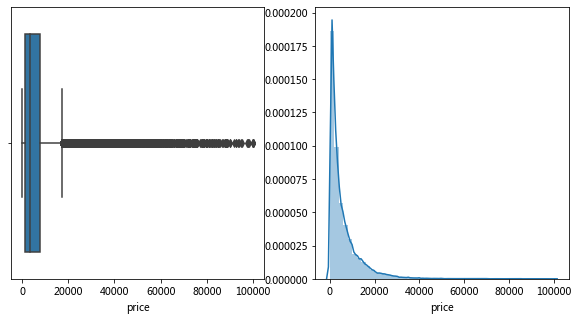

In [10]:
# 结局统计
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(df['price'], ax=axes[0])
sns.distplot(df['price'].dropna(), hist=True, ax=axes[1])
f.savefig('data/result/price-statis.png')

可以看出解决信息的分布不均匀，取log作为预测的对象

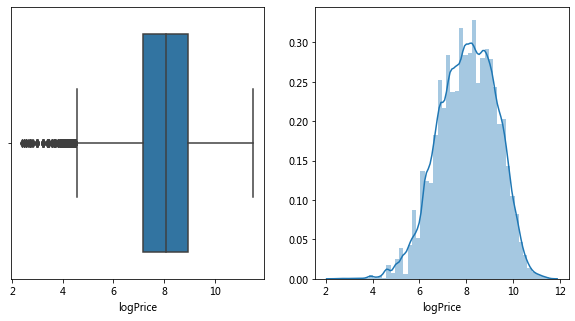

In [9]:
# 结局统计
df['logPrice'] = df['price'].apply(np.log)
f, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.boxplot(df['logPrice'], ax=axes[0])
sns.distplot(df['logPrice'].dropna(), hist=True, ax=axes[1])
f.savefig('data/result/log-price-statis.png')

In [10]:
# 特征进行分类
num_feats = [
    'power', 'kilometer', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
    'v_13', 'v_14', 'carAge'
]
bool_feats = ['gearbox', 'notRepairedDamage', 'seller', 'offerType']
cat_feats = ['model', 'brand', 'bodyType', 'fuelType', 
#              'regionCode'
            ]

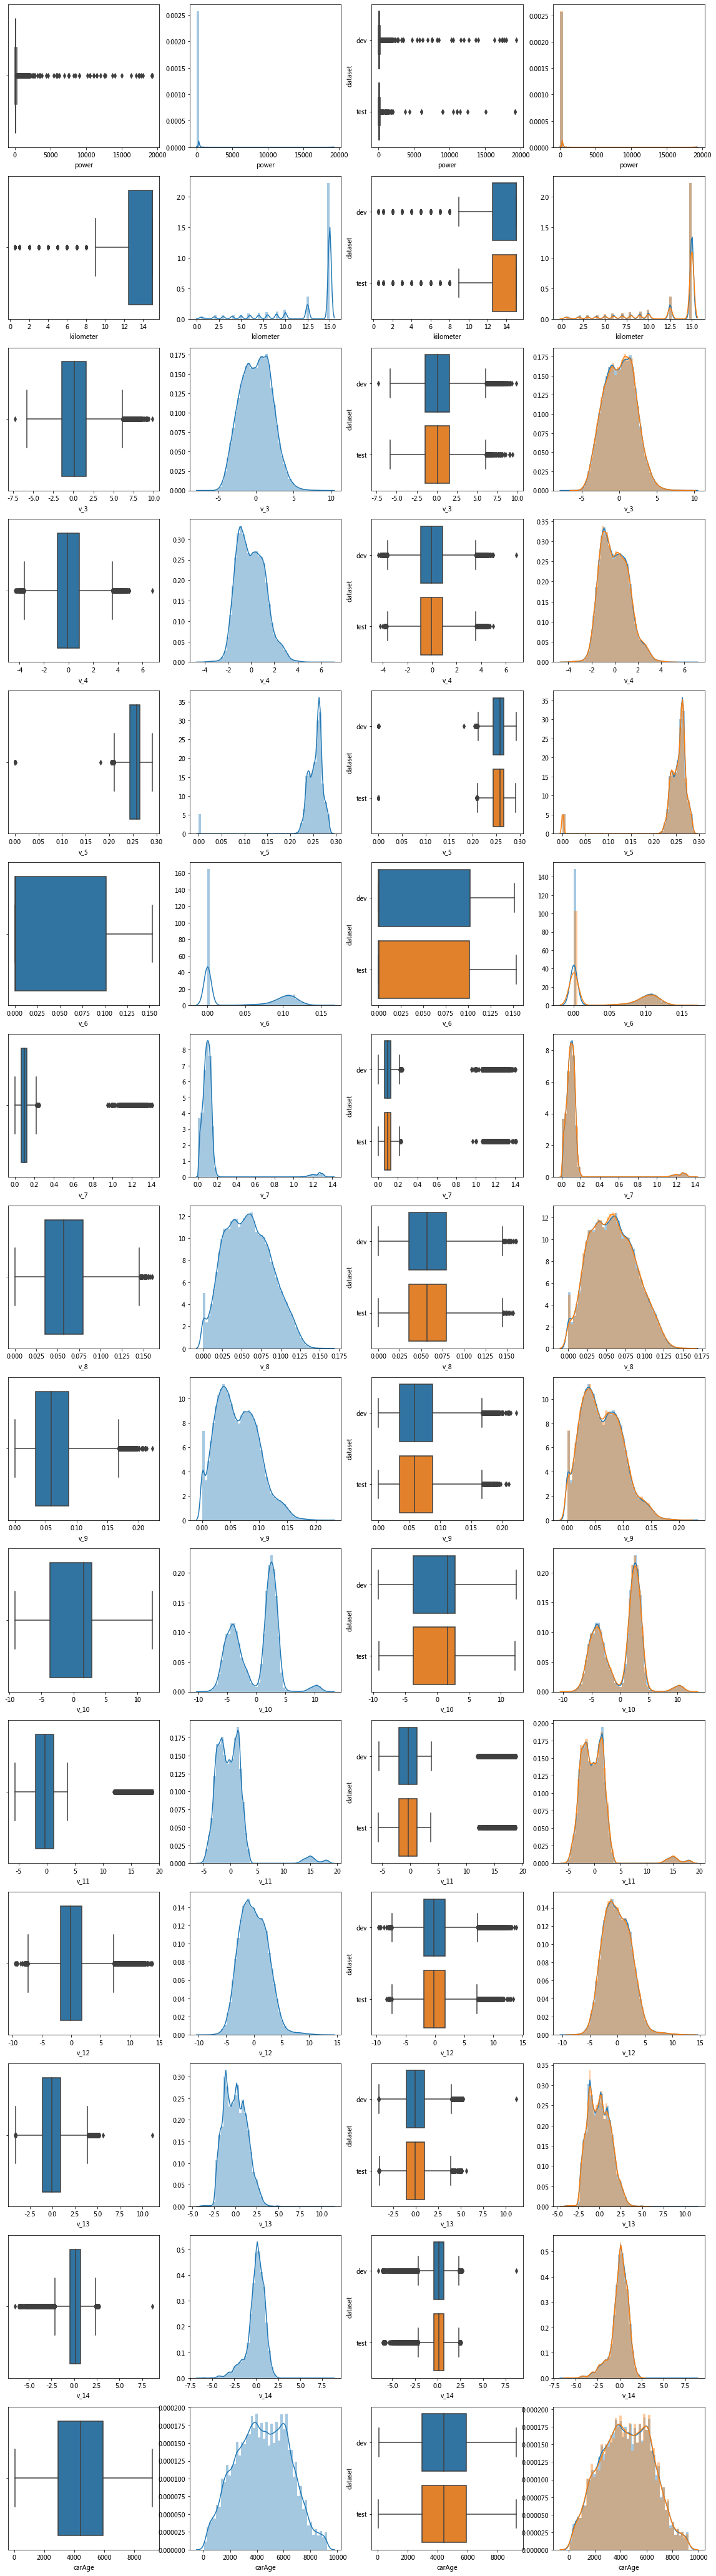

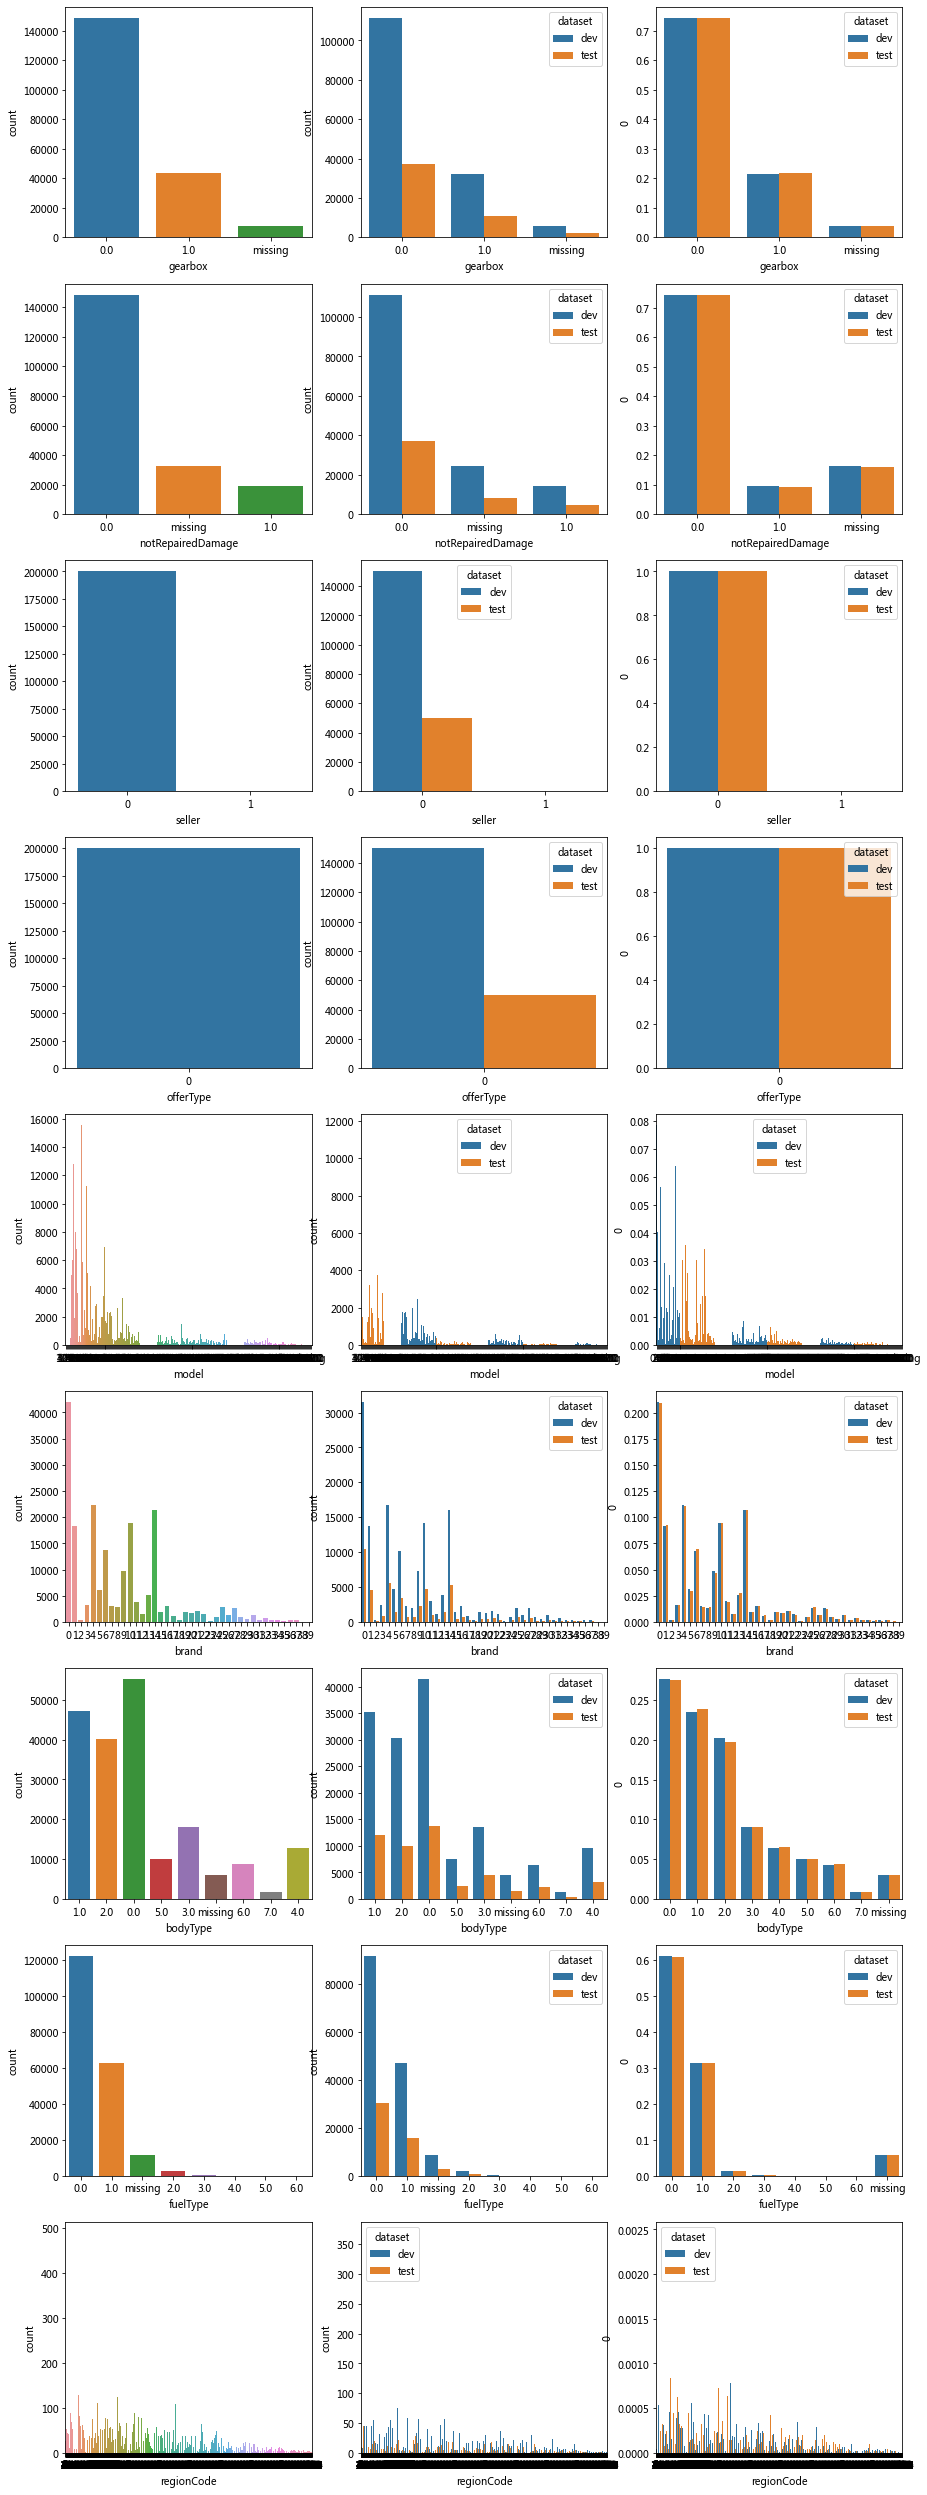

In [13]:
generate_img(data, num_feats, bool_feats + cat_feats, 'dataset', 'data/result', 'used-car')

In [14]:
characteristic_table, dfp = create_characteristic_table(
    data, num_feats, {x: x for x in num_feats}, bool_feats + cat_feats,
    {x: x for x in bool_feats + cat_feats}, 'missing', 'dataset', {'dev': 'dev', 'test': 'test'}
)

In [19]:
characteristic_table.to_csv('data/result/feature-statics.csv', index=False)

## 添加missing-indicator，分类变量one-hot处理

In [12]:
feature_manager = FeatureManager(
    num_features=num_feats + bool_feats, 
    categorical_features=cat_feats,
    num_config={'fillna': 'median'},
    categorical_config={'one_hot': True}
)
X_dev = feature_manager.get_model_features(df)
X_test = feature_manager.transform_feature(test)

In [13]:
[x for x in X_test.columns if x.find('miss') > 0]

['carAge_missing',
 'gearbox_missing',
 'notRepairedDamage_missing',
 'model_missing',
 'bodyType_missing',
 'fuelType_missing']

In [14]:
X_dev.shape

(150000, 328)

## 10折CV调参

In [15]:
kf = KFold(n_splits=10)
idxes = list(kf.split(X_dev))

In [18]:
def hyper_params_search_cv(hyper_params_iter, tune_iteration, model, idxes, X, y, random_state=0, verbose=True):
    params, metrics, best_boost_round = [], [], []
    for i, param_set in enumerate(ParameterSampler(hyper_params_iter, tune_iteration, random_state=random_state)):
        model.set_hyper_params(**param_set)
        params.append(param_set)
        val_metrics, best_rounds = [], []
        for tr_idx, val_idx in idxes:
            tr_x, tr_y = X.iloc[tr_idx, :], y.iloc[tr_idx]
            val_x, val_y = X.iloc[val_idx, :], y.iloc[val_idx]
            tr_dm, val_dm = to_xgb_dm(tr_x, tr_y), to_xgb_dm(val_x, val_y)
            model.train(tr_dm, val_dm)
            val_metrics.append(mean_absolute_error(model.predict(val_x), val_y))
            best_rounds.append(model.model.best_iteration)
           # print(val_metrics[-1], best_rounds[-1])
        best_boost_round.append(np.mean(best_rounds))
        metrics.append(np.mean(val_metrics))
        if verbose:
            print('[', i, '] ', param_set, 'mae: ', metrics[-1], ' best_boost_round: ', best_boost_round[-1])
    params_idx = np.argmin(metrics)
    cols = ['eta', 'max_depth', 'subsample', 'colsample_bytree', 'gamma', 'lambda']
    df = pd.DataFrame(params).reindex(columns=cols)
    df.insert(0, 'mae', pd.Series(metrics))
    df['best_boost_round'] = np.array(best_boost_round)
    df.at[params_idx, 'tag'] = 'best iter'
    print('best iter', params[params_idx], metrics[params_idx])
    return df

In [ ]:
model = XGBModel(seed=1024)
xgb_hyper_record = hyper_params_search_cv(
    {
        'eta': [0.3],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.5, 0.7, 0.9],
        'colsample_bytree': [0.5, 0.7, 0.9],
        'gamma': [0, 0.01, 0.03, 0.1, 0.3],
        'lambda': [0.1, 0.3, 1]
    }, 100, model, idxes, X_dev, df['logPrice'], random_state=1024
)

[ 0 ]  {'subsample': 0.5, 'max_depth': 9, 'lambda': 0.1, 'gamma': 0.1, 'eta': 0.3, 'colsample_bytree': 0.9} mae:  0.1448074125171593  best_boost_round:  39.4
[ 1 ]  {'subsample': 0.5, 'max_depth': 5, 'lambda': 1, 'gamma': 0.1, 'eta': 0.3, 'colsample_bytree': 0.7} mae:  0.14998809424155662  best_boost_round:  305.2
[ 2 ]  {'subsample': 0.7, 'max_depth': 9, 'lambda': 0.1, 'gamma': 0.1, 'eta': 0.3, 'colsample_bytree': 0.7} mae:  0.14528109037854514  best_boost_round:  58.2
[ 3 ]  {'subsample': 0.5, 'max_depth': 5, 'lambda': 1, 'gamma': 0.01, 'eta': 0.3, 'colsample_bytree': 0.5} mae:  0.15421806742742575  best_boost_round:  274.5
[ 4 ]  {'subsample': 0.9, 'max_depth': 9, 'lambda': 0.3, 'gamma': 0.03, 'eta': 0.3, 'colsample_bytree': 0.7} mae:  0.14100630500389416  best_boost_round:  97.7
[ 5 ]  {'subsample': 0.5, 'max_depth': 5, 'lambda': 0.3, 'gamma': 0.1, 'eta': 0.3, 'colsample_bytree': 0.7} mae:  0.152308733784121  best_boost_round:  239.6
[ 6 ]  {'subsample': 0.7, 'max_depth': 9, 'lambd

In [ ]:
# xgb_hyper = xgb_hyper_record[xgb_hyper_record['tag'] == 'best iter'].iloc[0, 2:-1].to_dict()
boost_round = int(xgb_hyper.pop('best_boost_round'))
model = XGBModel(num_boost_round=boost_round, seed=1024)
model.set_hyper_params(**xgb_hyper)
dev_dm = to_xgb_dm(X_dev, df['logPrice'])
model.train(dev_dm)

In [ ]:
pd.DataFrame(np.exp(model.predict(X_test)), index=test['SaleID'], columns=['price']).to_csv(
    'data/result/baseline-submit.csv')